In [1]:
import pandas as pd
import numpy as np

import os
import cv2 
import SimpleITK as sitk

from skimage.feature import greycomatrix
import matplotlib.pyplot as plt
import seaborn as sns

# Functions 

In [2]:
def reduceSize(image_np, mask_np):

    d,l,c = mask_np.shape
    dim = [[],[],[]]
    for k in range(d):
        if mask_np[k,:,:].max() == 0:
            continue
        else:
            dim[0].append(k)
        for i in range(l):
            if mask_np[k,i,:].max() == 0:
                continue
            else:
                dim[1].append(i)
            for j in range(c):
                if mask_np[k,i,j] == 1:
                    dim[2].append(j)
    
    image = image_np[min(dim[0]):max(dim[0])+1, min(dim[1]):max(dim[1])+1, min(dim[2]):max(dim[2])+1]

    return image

# Load Data 

In [3]:
os.chdir('..')
extractionPath = os.path.join(os.getcwd(),'data','extractionData')
imagePath = os.path.join(extractionPath, 'images_raw')
maskPath  = os.path.join(extractionPath, 'masks')
labelPath = os.path.join(extractionPath, 'label.csv')

## Mask

In [4]:
maskPath_lst = [os.path.join(maskPath, file) for file in os.listdir(maskPath)]
maskPath_lst.sort()

In [5]:
#Getting pixel array for every mask
maskNumpy_lst = [sitk.GetArrayFromImage(sitk.ReadImage(file)) for file in maskPath_lst]

#All masks must be binary masks with only 1 and 0.
normalize = lambda mask_object, m_max: np.where(m_max == mask_object, 1, 0)
maskNumpy_lst = [normalize(mask_np, mask_np.max()) for mask_np in maskNumpy_lst]

#Transforming to mask object
maskObject_lst = [sitk.GetImageFromArray(mask_np) for mask_np in maskNumpy_lst]

## Image

In [6]:
imagePath_lst = []
# r=root, d=directories, f = files
for r, d, f in os.walk(imagePath):
    for file in f:
        if '.dcm' in file:
            imagePath_lst.append(os.path.join(r, file))

In [7]:
imageObject_lst = [sitk.ReadImage(file) for file in imagePath_lst]

#Ordering by Patient ID number in order to match with the masks
imageObject_lst = sorted(imageObject_lst, key = lambda i: i.GetMetaData('0010|0020'))

In [8]:
imageNumpy_lst = [sitk.GetArrayFromImage(image) for image in imageObject_lst]

# Making Images

In [9]:
from skimage import exposure

PatientIDS = []
PatientIDS.append(imageObject_lst[0].GetMetaData('0010|0020')) #1181389 NO
PatientIDS.append(imageObject_lst[1].GetMetaData('0010|0020')) #123506 NO
PatientIDS.append(imageObject_lst[4].GetMetaData('0010|0020')) #1628856 NO
PatientIDS.append(imageObject_lst[5].GetMetaData('0010|0020')) #1733889 NO

PatientIDS.append(imageObject_lst[3].GetMetaData('0010|0020')) #1463024 YES
PatientIDS.append(imageObject_lst[7].GetMetaData('0010|0020')) #2370708 YES
PatientIDS.append(imageObject_lst[9].GetMetaData('0010|0020')) #2734320 YES
PatientIDS.append(imageObject_lst[93].GetMetaData('0010|0020')) #481499  YES

img0 = np.where(maskNumpy_lst[0] == 1, imageNumpy_lst[0], 0)
img1 = np.where(maskNumpy_lst[8] == 1, imageNumpy_lst[1], 0)
img4 = np.where(maskNumpy_lst[32] == 1, imageNumpy_lst[4], 0)
img5 = np.where(maskNumpy_lst[40] == 1, imageNumpy_lst[5], 0)

img3 = np.where(maskNumpy_lst[24] == 1, imageNumpy_lst[3], 0)
img7 = np.where(maskNumpy_lst[56] == 1, imageNumpy_lst[7],0)
img9 = np.where(maskNumpy_lst[72] == 1, imageNumpy_lst[9],0)
img93 = np.where(maskNumpy_lst[744] == 1, imageNumpy_lst[93],0)

images = [img0, img1, img4, img5,
          img3,img7,img9,img93]

masks = [maskNumpy_lst[0],  maskNumpy_lst[8]  ,maskNumpy_lst[32] ,maskNumpy_lst[40],
         maskNumpy_lst[24], maskNumpy_lst[56] ,maskNumpy_lst[72] ,maskNumpy_lst[744]]

for i,image in enumerate(images):
    images[i] = exposure.rescale_intensity(image, out_range=(0, 127))
    
imagesReduced = list(map(lambda image,mask: reduceSize(image, mask), images, masks))

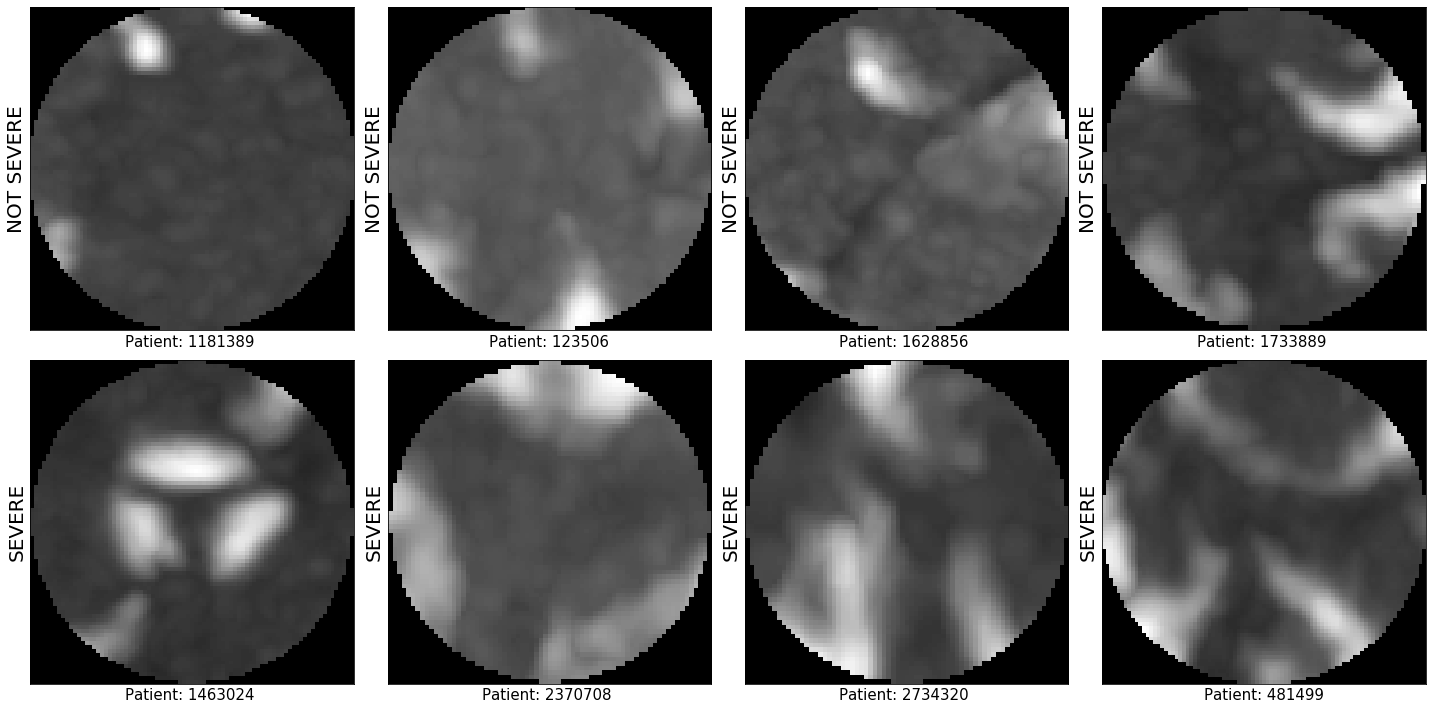

In [10]:
fig, axs = plt.subplots(2,4,figsize=(20,10))

for i,ax in zip(range(8),axs.flatten()):
    if i<4:
        ax.set_ylabel('NOT SEVERE',fontsize = 20)
    else:
        ax.set_ylabel('SEVERE',fontsize = 20)

    ax.imshow(imagesReduced[i][0], cmap = 'gray')
    ax.set_xlabel('Patient: {}'.format(PatientIDS[i]), fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.ticklabel_format()
plt.savefig(os.path.join('figures','glcm',f'patientsMasks1.png'),format = 'png')    
plt.show()

In [11]:
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
dist = [1]
levels = 128

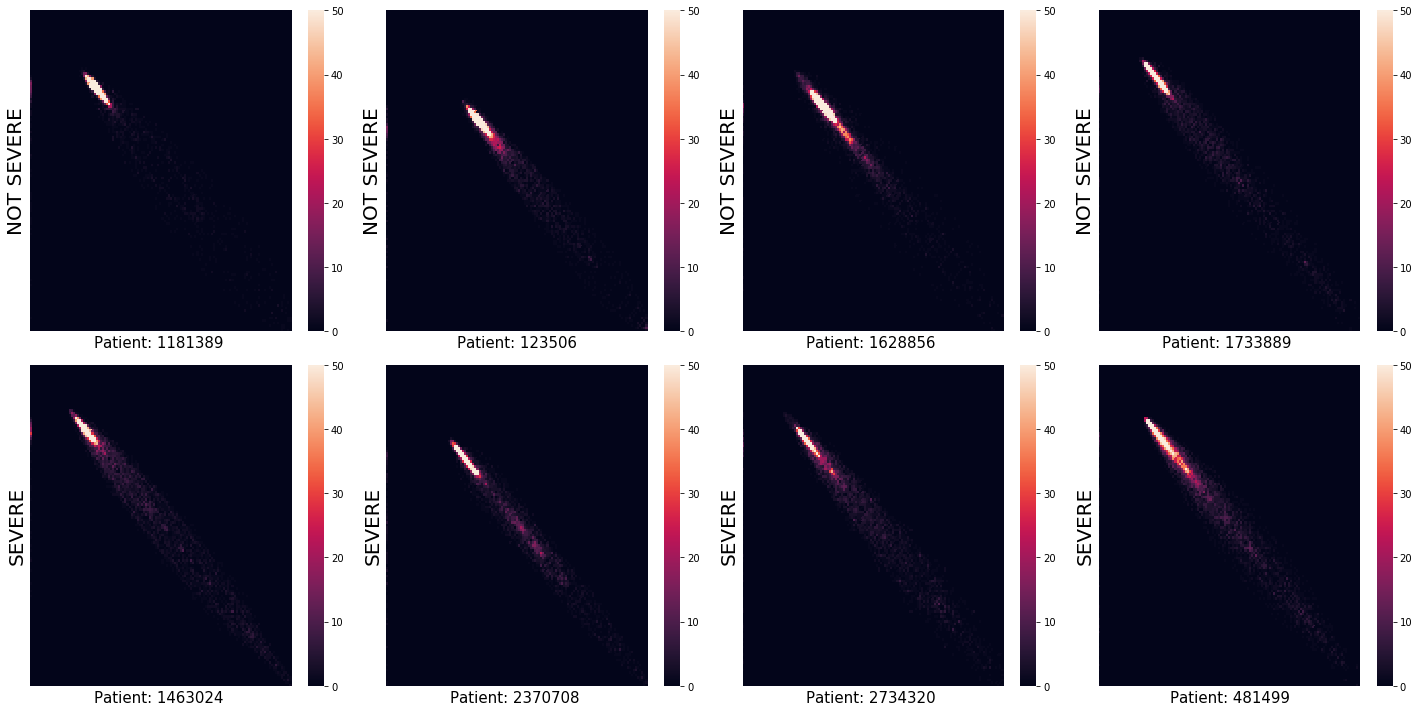

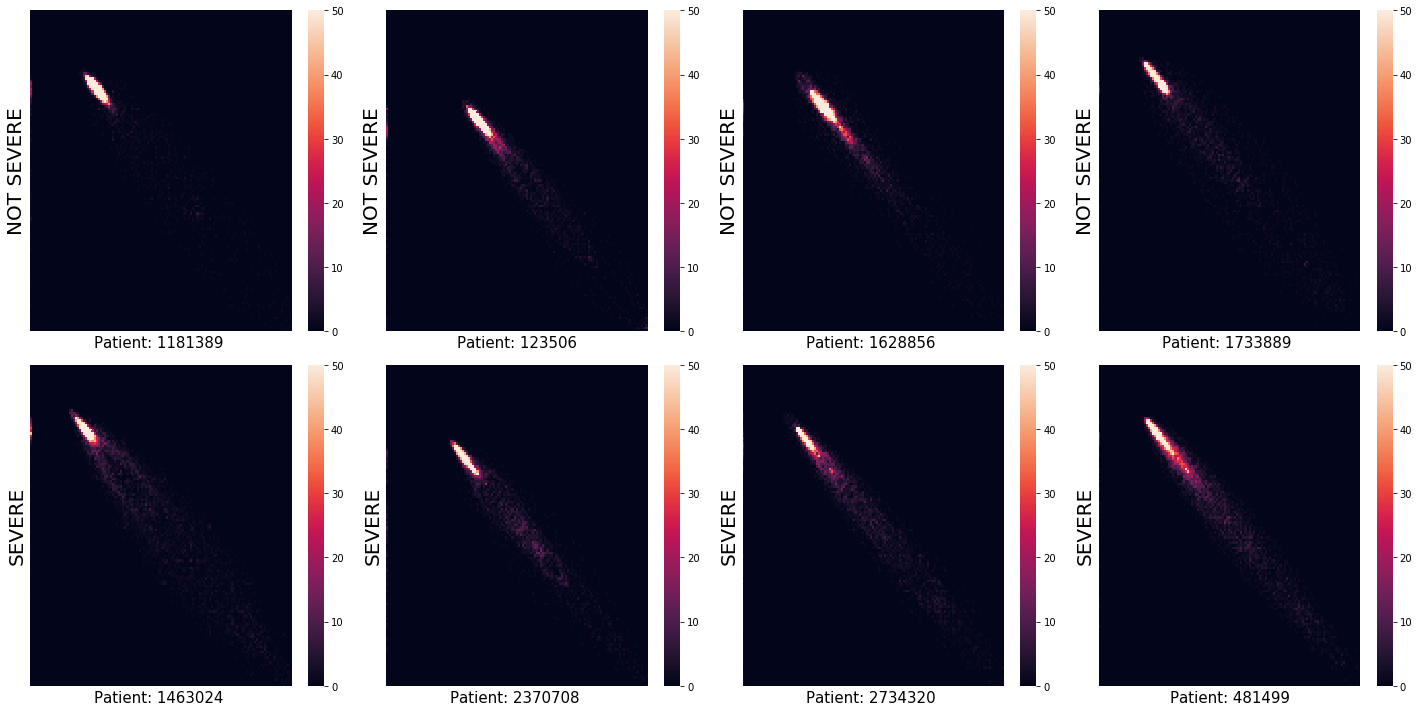

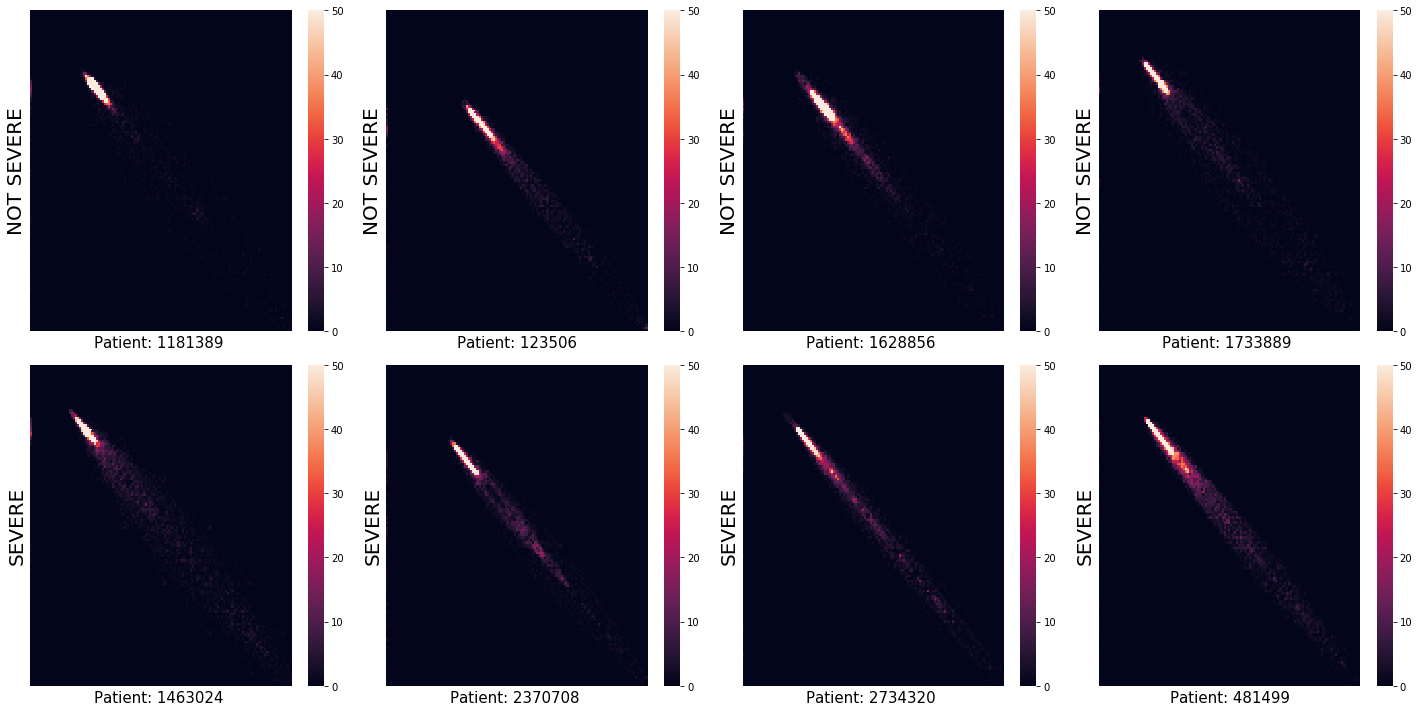

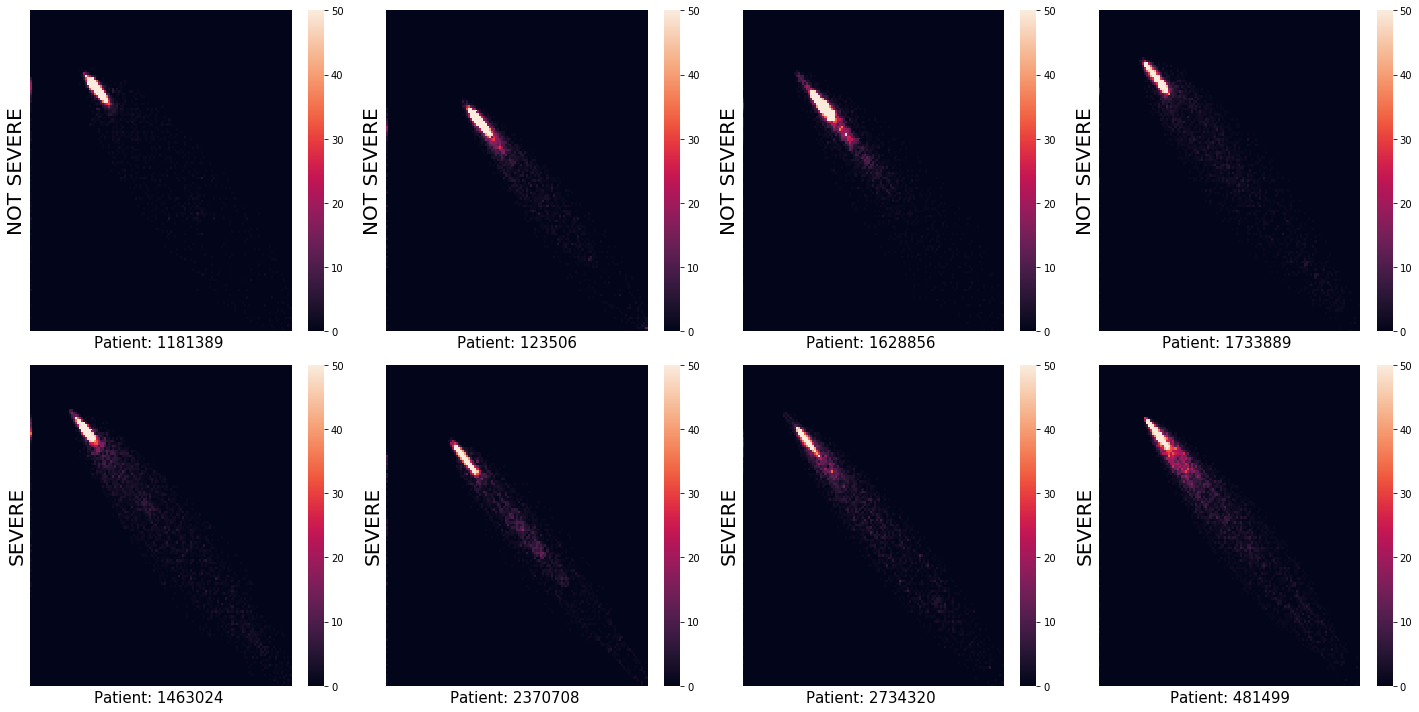

In [12]:
for j in np.arange(len(angles)):
    fig, axs = plt.subplots(2,4,figsize=(20,10))


    for i,ax in zip(range(8), axs.flatten()) :


        glcm_image = greycomatrix(imagesReduced[i][0], dist, angles, levels, symmetric=True)
        g=sns.heatmap(glcm_image[1:,:-1,0,j],ax = ax, vmin=0, vmax=50)
        g.set_xlabel('Patient: {}'.format(PatientIDS[i]), fontsize=15)
        if i<4:
            g.set_ylabel('NOT SEVERE',fontsize = 20)
        else:
            g.set_ylabel('SEVERE',fontsize = 20)
        
        g.set_xticks([])
        g.set_yticks([])
        
    plt.tight_layout()
    plt.ticklabel_format()
    plt.savefig(os.path.join('figures','glcm','normalScale',f'normalScale{angles[j]*180/np.pi}.png'),format = 'png')    
    plt.show()

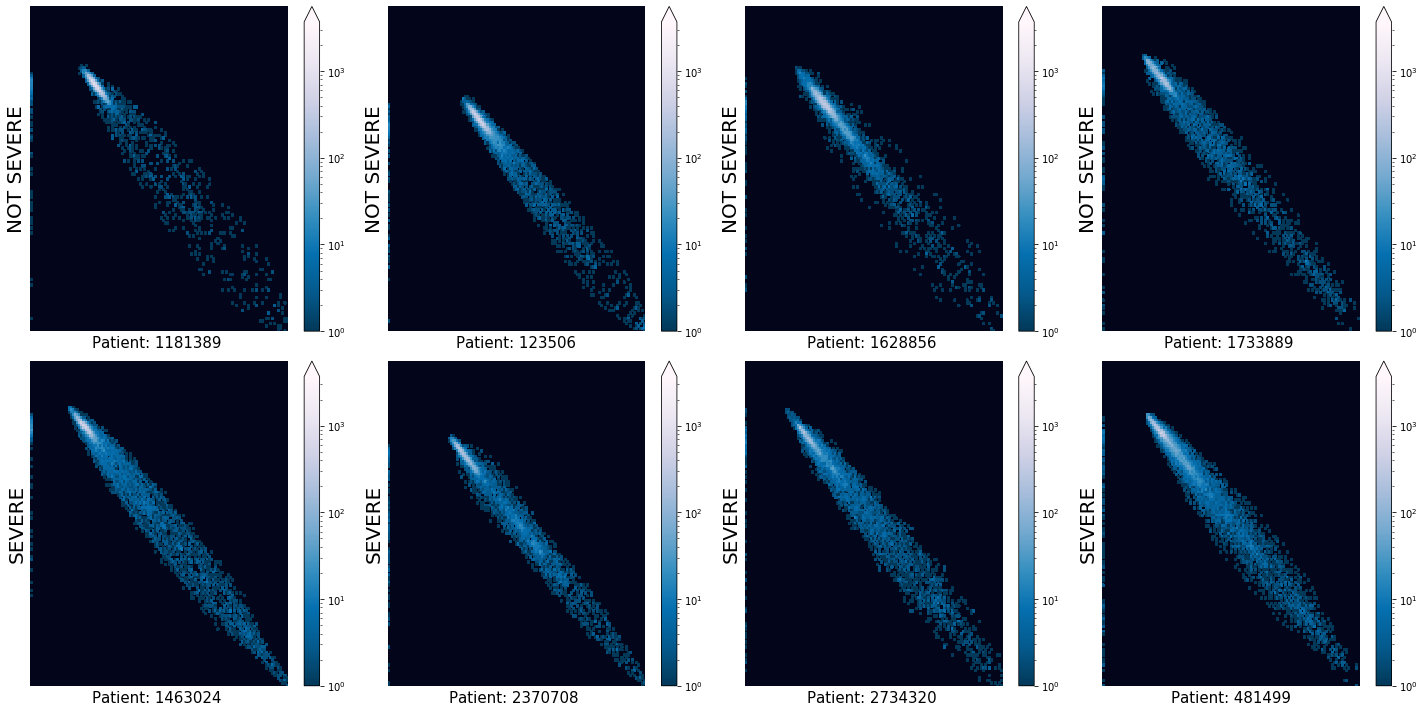

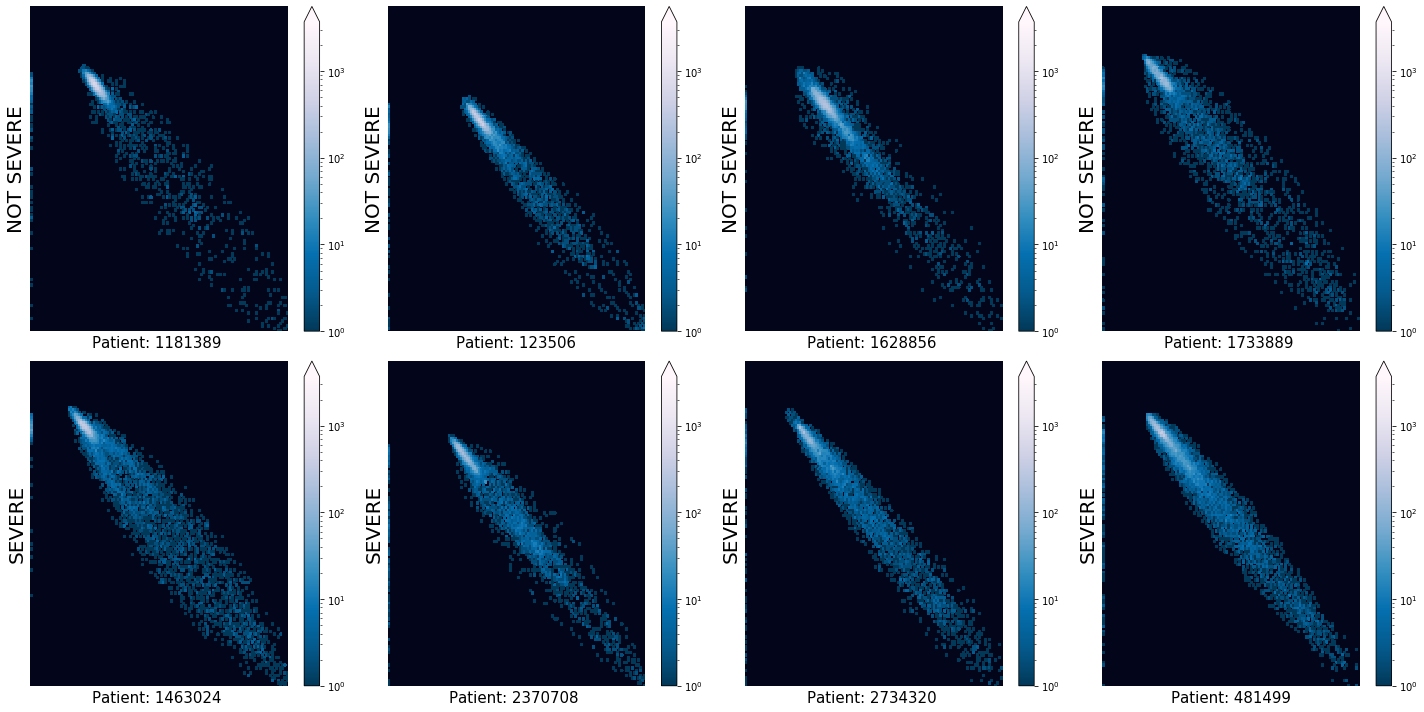

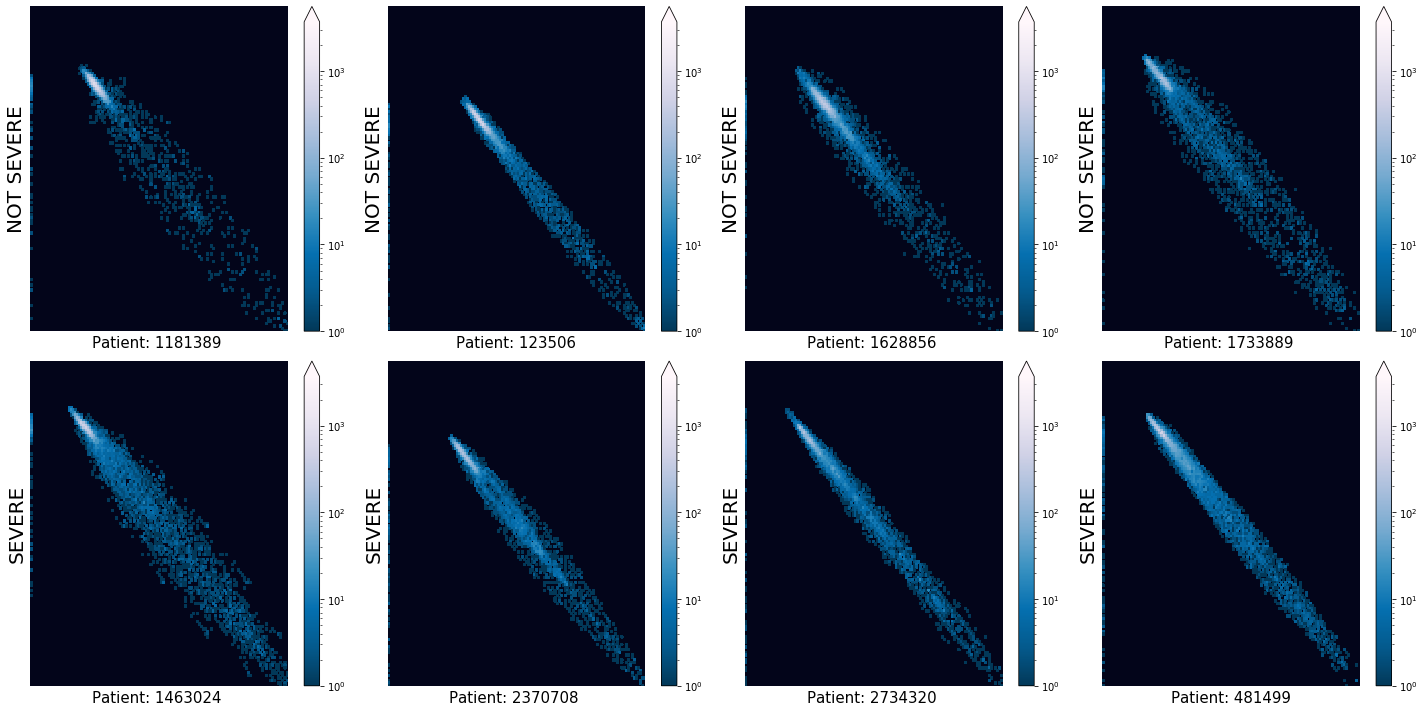

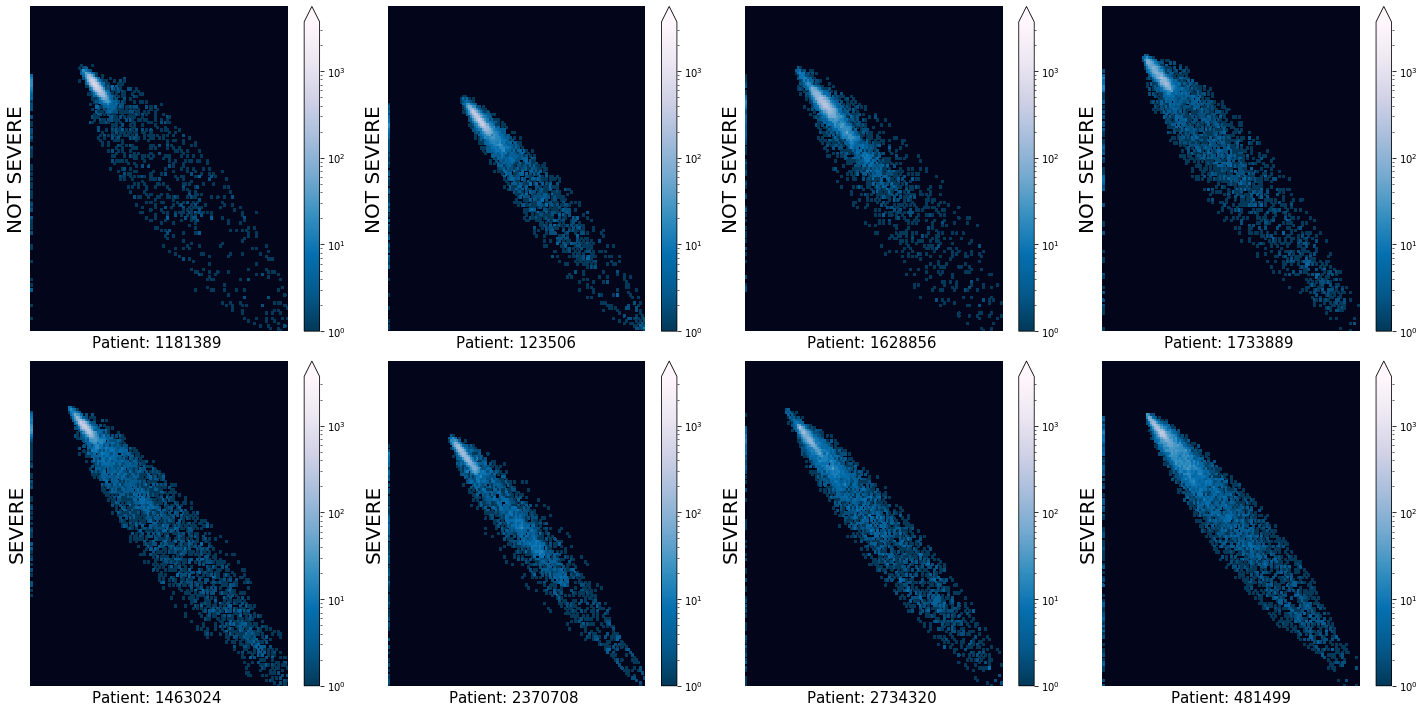

In [13]:
import matplotlib.colors as colors

for j in np.arange(len(angles)):
    fig, axs = plt.subplots(2,4,figsize=(20,10))

    for i, ax in zip(np.arange(8), axs.flatten()):

        glcm_image = greycomatrix(imagesReduced[i][0], dist, angles, levels, symmetric=True)
        g=sns.heatmap(glcm_image[1:,:-1,0,j],ax = ax, vmin=0, vmax=500, cbar = False)
        g.set_xlabel('Patient: {}'.format(PatientIDS[i]), fontsize=15)
        if i<4:
            g.set_ylabel('NOT SEVERE',fontsize = 20)
        else:
            g.set_ylabel('SEVERE',fontsize = 20)
        
        g.set_xticks([])
        g.set_yticks([])
        
        pcm = ax.pcolor(glcm_image[1:,:-1,0,j],
                       norm=colors.LogNorm(vmin = 1, vmax = 3696),
                       cmap='PuBu_r')

        fig.colorbar(pcm, ax=ax, extend='max')
        
    plt.tight_layout()
    plt.ticklabel_format()
    plt.savefig(os.path.join('figures','glcm','logScale',f'logScale{angles[j]*180/np.pi}.png'),format = 'png')
    plt.show()